## Imports and Data

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import prettyTable, project_root

PROJECT_ROOT = Path.cwd().parents[0]  # notebook is in notebooks/
DATA_DIR = PROJECT_ROOT / "data"

pd.set_option("display.max_columns", 20)
sns.set_theme(style="darkgrid", palette="bright", context="notebook")


In [2]:
ig_oas = pd.read_csv(DATA_DIR / "ig_oas.csv", parse_dates=["date"], index_col="date")
dgs10 = pd.read_csv(DATA_DIR / "dgs10.csv", parse_dates=["date"], index_col="date")
t10y2y = pd.read_csv(DATA_DIR / "t10y2y.csv", parse_dates=["date"], index_col="date")

df = (
    ig_oas.rename(columns={"value": "ig_oas"})
    .join(dgs10.rename(columns={"value": "dgs10"}), how="inner")
    .join(t10y2y.rename(columns={"value": "t10y2y"}), how="inner")
    .sort_index()
)

df.head()

,ig_oas,dgs10,t10y2y
date,,,
1996-12-31,0.60,6.43,0.55
1997-01-01,NaN,NaN,NaN
1997-01-02,0.60,6.54,0.57
1997-01-03,0.61,6.52,0.57
1997-01-06,0.61,6.54,0.57


In [3]:
df.info()

df.describe(percentiles=[0.1, 0.5, 0.9]).T

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7549 entries, 1996-12-31 to 2025-12-05
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ig_oas  7456 non-null   float64
 1   dgs10   7237 non-null   float64
 2   t10y2y  7237 non-null   float64
dtypes: float64(3)
memory usage: 235.9 KB


,count,mean,std,min,10%,50%,90%,max
ig_oas,7456.0,1.473006,0.821139,0.53,0.87,1.28,2.180,6.56
dgs10,7237.0,3.572841,1.448409,0.52,1.72,3.70,5.544,6.98
t10y2y,7237.0,0.976999,0.955812,-1.08,-0.14,0.83,2.360,2.91


## Plots and Statistics

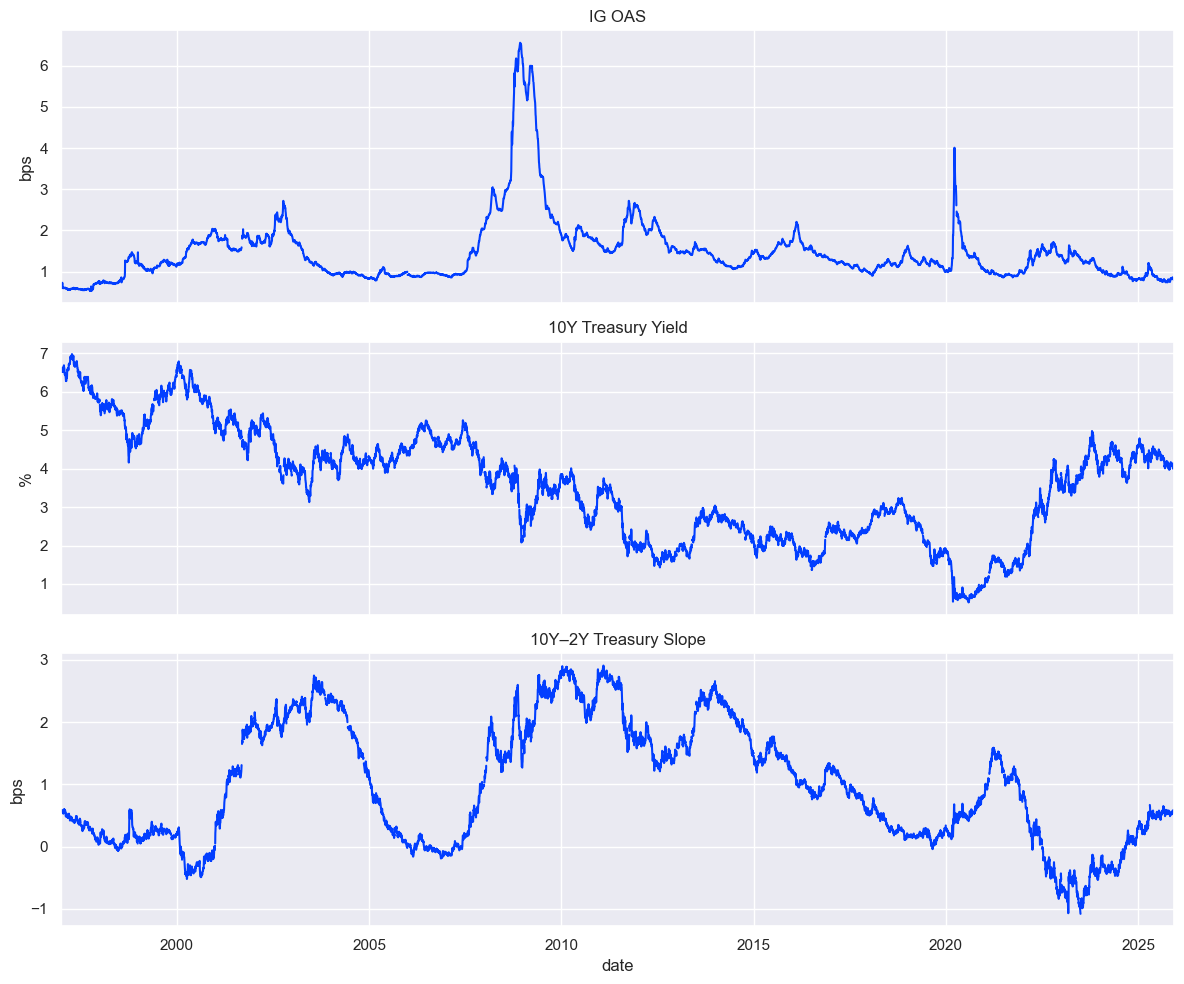

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

df["ig_oas"].plot(ax=axes[0])
axes[0].set_title("IG OAS")
axes[0].set_ylabel("bps")

df["dgs10"].plot(ax=axes[1])
axes[1].set_title("10Y Treasury Yield")
axes[1].set_ylabel("%")

df["t10y2y"].plot(ax=axes[2])
axes[2].set_title("10Y–2Y Treasury Slope")
axes[2].set_ylabel("bps")

plt.tight_layout()
plt.show()


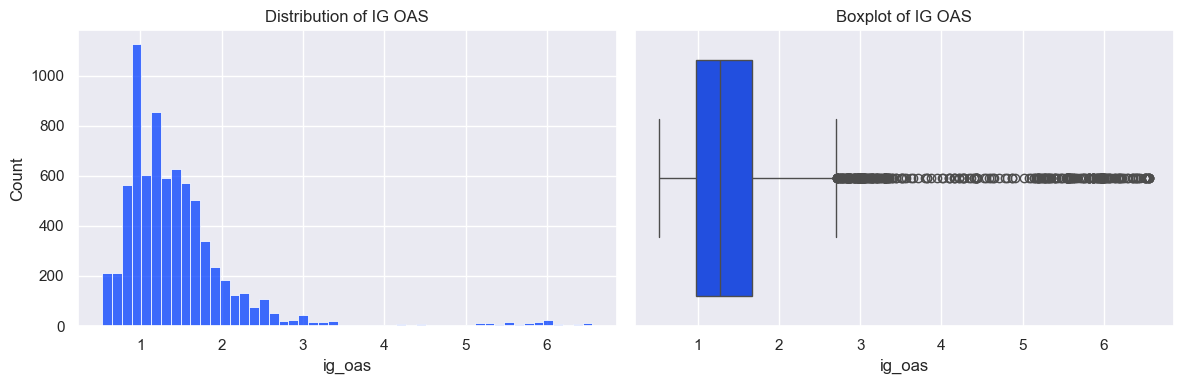

count    7456.000000
mean        1.473006
std         0.821139
min         0.530000
50%         1.280000
80%         1.770000
90%         2.180000
95%         2.602500
max         6.560000
Name: ig_oas, dtype: float64

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["ig_oas"].dropna(), bins=50, ax=ax[0])
ax[0].set_title("Distribution of IG OAS")

sns.boxplot(x=df["ig_oas"], ax=ax[1])
ax[1].set_title("Boxplot of IG OAS")

plt.tight_layout()
plt.show()

df["ig_oas"].describe(percentiles=[0.8, 0.9, 0.95])

## Initial Modeling

In [6]:
stress_threshold = df["ig_oas"].quantile(0.90)
stress_threshold

np.float64(2.18)

In [7]:
df["regime_stress"] = (df["ig_oas"] >= stress_threshold).astype(int)
df["regime_stress"].value_counts(normalize=True)

regime_stress
0    0.900252
1    0.099748
Name: proportion, dtype: float64

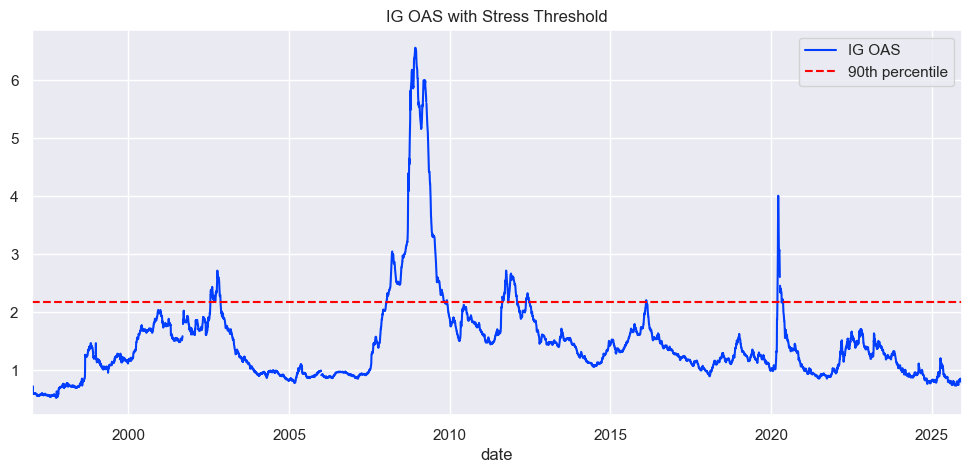

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
df["ig_oas"].plot(ax=ax, label="IG OAS")
ax.axhline(stress_threshold, color="red", linestyle="--", label="90th percentile")
ax.set_title("IG OAS with Stress Threshold")
ax.legend()
plt.show()

In [9]:
df["ig_oas_chg"] = df["ig_oas"].diff()
df["dgs10_chg"] = df["dgs10"].diff()
df["t10y2y_chg"] = df["t10y2y"].diff()

# Rolling 20-day volatility of OAS
window = 20
df["ig_oas_roll_vol"] = df["ig_oas_chg"].rolling(window).std()

# Simple lags
df["ig_oas_lag1"] = df["ig_oas"].shift(1)
df["dgs10_lag1"] = df["dgs10"].shift(1)
df["t10y2y_lag1"] = df["t10y2y"].shift(1)

df_features = df.dropna().copy()
df_features.head()

,ig_oas,dgs10,t10y2y,regime_stress,ig_oas_chg,dgs10_chg,t10y2y_chg,ig_oas_roll_vol,ig_oas_lag1,dgs10_lag1,t10y2y_lag1
date,,,,,,,,,,,
1997-01-30,0.60,6.61,0.60,0,0.00,-0.02,0.01,0.037975,0.60,6.63,0.59
1997-01-31,0.61,6.53,0.59,0,0.01,-0.08,-0.01,0.037975,0.60,6.61,0.60
1997-02-03,0.61,6.47,0.58,0,0.00,-0.06,-0.01,0.037975,0.61,6.53,0.59
1997-02-04,0.61,6.45,0.57,0,0.00,-0.02,-0.01,0.037975,0.61,6.47,0.58
1997-02-05,0.60,6.47,0.56,0,-0.01,0.02,-0.01,0.037975,0.61,6.45,0.57


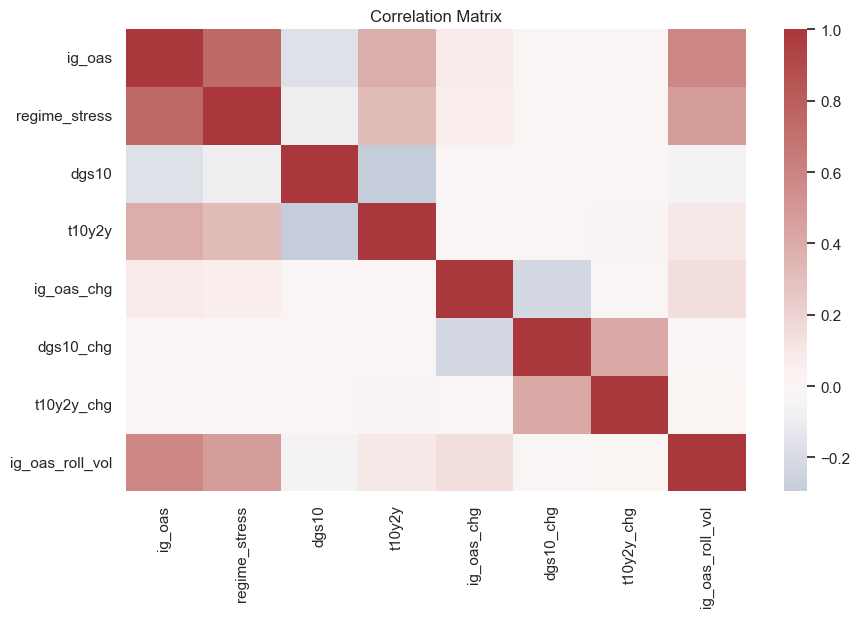

In [10]:
corr_cols = [
    "ig_oas",
    "regime_stress",
    "dgs10",
    "t10y2y",
    "ig_oas_chg",
    "dgs10_chg",
    "t10y2y_chg",
    "ig_oas_roll_vol",
]

plt.figure(figsize=(10, 6))
sns.heatmap(df_features[corr_cols].corr(), annot=False, cmap="vlag", center=0)
plt.title("Correlation Matrix")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

feature_cols = [
    "ig_oas_lag1",      # yesterday's spread
    "dgs10_lag1",       # yesterday's 10Y rate
    "t10y2y_lag1",      # yesterday's slope
    "ig_oas_roll_vol",  # recent volatility
]

X = df_features[feature_cols]
y = df_features["regime_stress"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False  # time series → no random shuffle
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1671
           1       1.00      0.88      0.94        26

    accuracy                           1.00      1697
   macro avg       1.00      0.94      0.97      1697
weighted avg       1.00      1.00      1.00      1697

ROC AUC: 0.9998849146066381


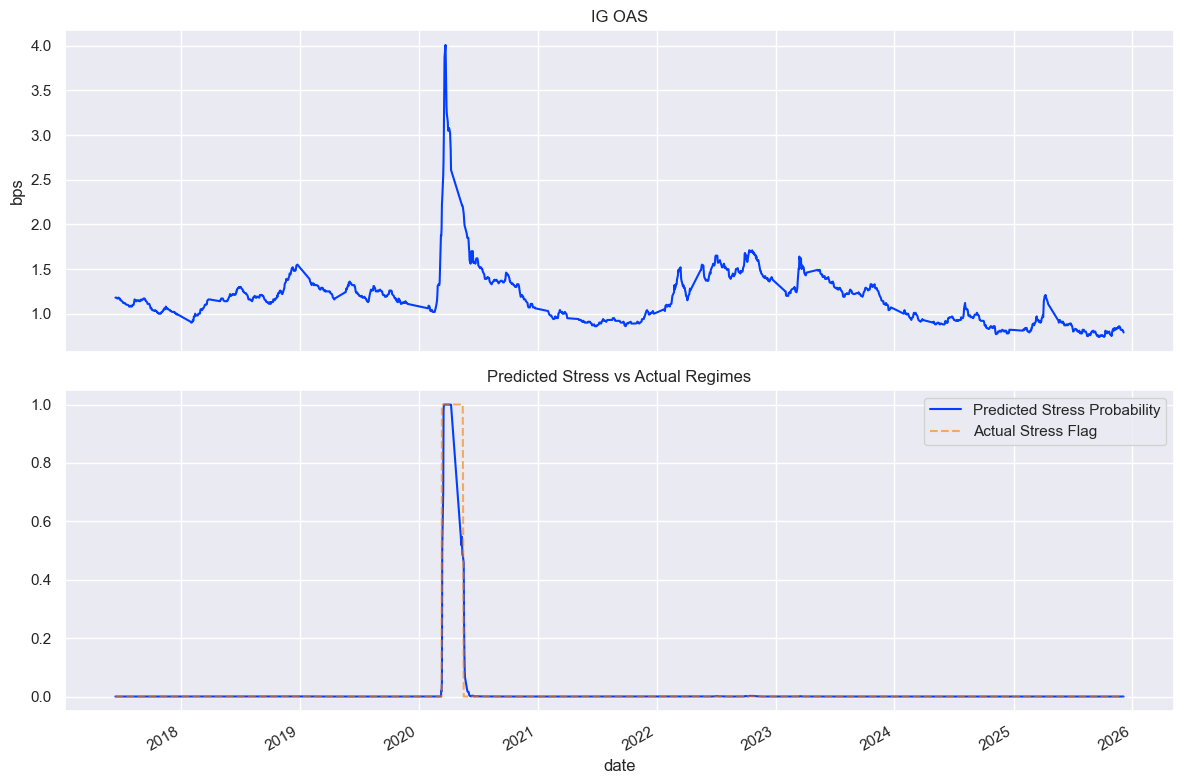

In [12]:
df_pred = df_features.loc[X_test.index].copy()
df_pred["stress_prob"] = y_proba
df_pred["regime_stress_pred"] = y_pred

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

df_pred["ig_oas"].plot(ax=ax[0])
ax[0].set_title("IG OAS")
ax[0].set_ylabel("bps")

df_pred["stress_prob"].plot(ax=ax[1], label="Predicted Stress Probability")
df_pred["regime_stress"].plot(
    ax=ax[1], secondary_y=False, linestyle="--", alpha=0.6, label="Actual Stress Flag"
)
ax[1].set_title("Predicted Stress vs Actual Regimes")
ax[1].legend()

plt.tight_layout()
plt.show()


## Adjusting Features

In [13]:
df = df.copy()
df = df.dropna(subset=["ig_oas", "dgs10", "t10y2y"]).sort_index()

# Ensure correct units interpretation:
# ig_oas is typically in percent (e.g., 1.2 meaning 120 bps) on FRED for some series;
# dgs10 is percent; t10y2y is percent/points depending on series.
# We won't change units yet—just be consistent.
df.tail()

,ig_oas,dgs10,t10y2y,regime_stress,ig_oas_chg,dgs10_chg,t10y2y_chg,ig_oas_roll_vol,ig_oas_lag1,dgs10_lag1,t10y2y_lag1
date,,,,,,,,,,,
2025-12-01,0.82,4.09,0.55,0,0.00,0.07,0.00,0.011910,0.82,4.02,0.55
2025-12-02,0.81,4.09,0.58,0,-0.01,0.00,0.03,0.012096,0.82,4.09,0.55
2025-12-03,0.81,4.06,0.57,0,0.00,-0.03,-0.01,0.011239,0.81,4.09,0.58
2025-12-04,0.80,4.11,0.59,0,-0.01,0.05,0.02,0.011192,0.81,4.06,0.57
2025-12-05,0.79,4.14,0.58,0,-0.01,0.03,-0.01,0.010195,0.80,4.11,0.59


In [14]:
stress_q = 0.90
stress_threshold = df["ig_oas"].quantile(stress_q)
df["stress"] = (df["ig_oas"] >= stress_threshold).astype(int)

df["stress"].value_counts(normalize=True), stress_threshold

(stress
 0    0.899128
 1    0.100872
 Name: proportion, dtype: float64,
 np.float64(2.18))

In [15]:
# creating lagged values
import numpy as np

def lag(s, k=1):
    return s.shift(k)

# Changes (macro)
df["dgs10_chg1"] = df["dgs10"].diff()
df["t10y2y_chg1"] = df["t10y2y"].diff()

# Rolling vol (lagged to avoid using today's value)
w = 20
df["dgs10_vol20"] = lag(df["dgs10_chg1"], 1).rolling(w).std()
df["t10y2y_vol20"] = lag(df["t10y2y_chg1"], 1).rolling(w).std()

# Lags of levels (macro levels are allowed)
df["dgs10_lag1"] = lag(df["dgs10"], 1)
df["t10y2y_lag1"] = lag(df["t10y2y"], 1)

# Lags of changes
df["dgs10_chg1_lag1"] = lag(df["dgs10_chg1"], 1)
df["t10y2y_chg1_lag1"] = lag(df["t10y2y_chg1"], 1)

# Optional: interaction (macro regime proxy)
df["rate_level_x_slope"] = df["dgs10_lag1"] * df["t10y2y_lag1"]

model_df = df.dropna().copy()
model_df.head()

,ig_oas,dgs10,t10y2y,regime_stress,ig_oas_chg,dgs10_chg,t10y2y_chg,ig_oas_roll_vol,ig_oas_lag1,dgs10_lag1,t10y2y_lag1,stress,dgs10_chg1,t10y2y_chg1,dgs10_vol20,t10y2y_vol20,dgs10_chg1_lag1,t10y2y_chg1_lag1,rate_level_x_slope
date,,,,,,,,,,,,,,,,,,,
1997-01-31,0.61,6.53,0.59,0,0.01,-0.08,-0.01,0.037975,0.60,6.61,0.60,0,-0.08,-0.01,0.053891,0.016819,-0.02,0.01,3.9660
1997-02-03,0.61,6.47,0.58,0,0.00,-0.06,-0.01,0.037975,0.61,6.53,0.59,0,-0.06,-0.01,0.051858,0.016512,-0.08,-0.01,3.8527
1997-02-04,0.61,6.45,0.57,0,0.00,-0.02,-0.01,0.037975,0.61,6.47,0.58,0,-0.02,-0.01,0.053398,0.016694,-0.06,-0.01,3.7526
1997-02-05,0.60,6.47,0.56,0,-0.01,0.02,-0.01,0.037975,0.61,6.45,0.57,0,0.02,-0.01,0.053260,0.016859,-0.02,-0.01,3.6765
1997-02-06,0.60,6.49,0.58,0,0.00,0.02,0.02,0.037683,0.60,6.47,0.56,0,0.02,0.02,0.052965,0.016311,0.02,-0.01,3.6232


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

feature_cols = [
    "dgs10_lag1",
    "t10y2y_lag1",
    "dgs10_chg1_lag1",
    "t10y2y_chg1_lag1",
    "dgs10_vol20",
    "t10y2y_vol20",
    "rate_level_x_slope",
]

X = model_df[feature_cols]
y = model_df["stress"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

# Walk-forward by calendar year
years = sorted(model_df.index.year.unique())

results = []
min_train_years = 5  # require at least 5 years before testing
for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = model_df.index.year.isin(train_years)
    test_idx = model_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    # Skip years with no class diversity
    if y_test.nunique() < 2 or y_train.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    results.append((test_year, auc, int(test_idx.sum())))

results[:5], len(results)

([(2009, 0.9522586169985013, 200),
  (2011, 0.9622282608695651, 218),
  (2012, 0.7339393939393939, 183),
  (2016, 0.6035353535353536, 200),
  (2020, 0.9606593406593406, 201)],
 5)

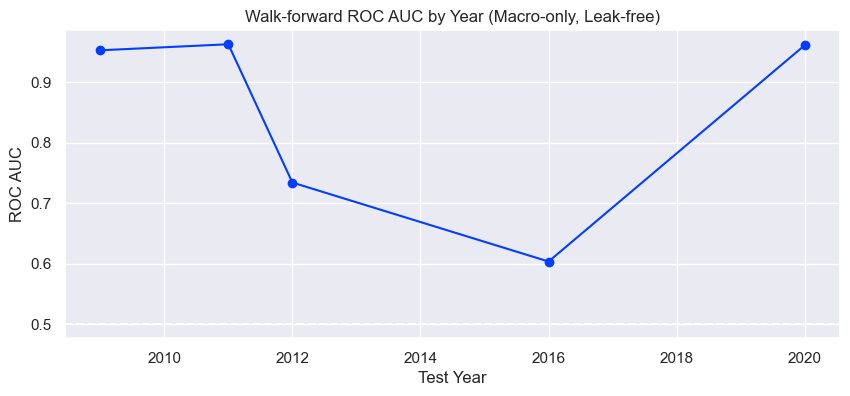

,year,auc,n_obs
count,5.000000,5.000000,5.000000
mean,2013.600000,0.842524,200.400000
std,4.393177,0.165252,12.381438
min,2009.000000,0.603535,183.000000
25%,2011.000000,0.733939,200.000000
50%,2012.000000,0.952259,200.000000
75%,2016.000000,0.960659,201.000000
max,2020.000000,0.962228,218.000000


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

res_df = pd.DataFrame(results, columns=["year", "auc", "n_obs"])

plt.figure(figsize=(10, 4))
plt.plot(res_df["year"], res_df["auc"], marker="o")
plt.axhline(0.5, linestyle="--")
plt.title("Walk-forward ROC AUC by Year (Macro-only, Leak-free)")
plt.ylabel("ROC AUC")
plt.xlabel("Test Year")
plt.show()

res_df.describe()

In [18]:
res_df

,year,auc,n_obs
0,2009,0.952259,200
1,2011,0.962228,218
2,2012,0.733939,183
3,2016,0.603535,200
4,2020,0.960659,201


In [19]:
# This should NOT exist in feature set anymore:
set(feature_cols) & {"ig_oas", "ig_oas_lag1", "ig_oas_roll_vol"}

set()

In [20]:
# Observation-weighted mean ROC AUC across walk-forward years.

import numpy as np

weighted_auc = np.average(
    res_df["auc"],
    weights=res_df["n_obs"]
)

weighted_auc

np.float64(0.8466347220955814)

In [21]:
# If I pool all out-of-sample predictions across time, how well do they rank stress vs normal?
from sklearn.metrics import roc_auc_score

all_y = []
all_proba = []

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = model_df.index.year.isin(train_years)
    test_idx = model_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    if y_test.nunique() < 2 or y_train.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

In [22]:
y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)

pooled_auc = roc_auc_score(y_all, proba_all)
pooled_auc

0.939448785365131

In [23]:
res_df["auc"].describe()

count    5.000000
mean     0.842524
std      0.165252
min      0.603535
25%      0.733939
50%      0.952259
75%      0.960659
max      0.962228
Name: auc, dtype: float64

## Predicting Stress Entry Points

In [24]:
df = df.copy().dropna(subset=["ig_oas", "dgs10", "t10y2y"]).sort_index()

stress_q = 0.90
stress_threshold = df["ig_oas"].quantile(stress_q)

df["stress"] = (df["ig_oas"] >= stress_threshold).astype(int)
stress_threshold, df["stress"].value_counts(normalize=True)

(np.float64(2.18),
 stress
 0    0.899128
 1    0.100872
 Name: proportion, dtype: float64)

In [25]:
H = 21  # horizon (trading days)

# Will stress occur at any point in the next H days?
# Equivalent to a forward-looking "max" of stress over the next H days.
df["stress_in_next_H"] = (
    df["stress"]
      .shift(-1)                     # start "tomorrow" so it's truly forward
      .rolling(H, min_periods=H)
      .max()
)

# Entry label: tomorrow->H contains stress AND today is not stress
df["stress_entry_H"] = ((df["stress"] == 0) & (df["stress_in_next_H"] == 1)).astype(int)

df[["stress", "stress_in_next_H", "stress_entry_H"]].tail(30)

,stress,stress_in_next_H,stress_entry_H
date,,,
2025-10-23,0,0.0,0
2025-10-24,0,0.0,0
2025-10-27,0,0.0,0
2025-10-28,0,0.0,0
2025-10-29,0,0.0,0
2025-10-30,0,0.0,0
2025-10-31,0,0.0,0
2025-11-03,0,0.0,0
2025-11-04,0,0.0,0


In [26]:
df["stress_entry_H"].value_counts(normalize=True), df["stress_entry_H"].sum()


(stress_entry_H
 0    0.98132
 1    0.01868
 Name: proportion, dtype: float64,
 np.int64(135))

In [27]:
model_df = df.copy()

# Macro changes
model_df["dgs10_chg1"] = model_df["dgs10"].diff()
model_df["t10y2y_chg1"] = model_df["t10y2y"].diff()

# Lags of macro levels
model_df["dgs10_lag1"] = model_df["dgs10"].shift(1)
model_df["t10y2y_lag1"] = model_df["t10y2y"].shift(1)

# Lags of changes
model_df["dgs10_chg1_lag1"] = model_df["dgs10_chg1"].shift(1)
model_df["t10y2y_chg1_lag1"] = model_df["t10y2y_chg1"].shift(1)

# Rolling vol (computed on lagged changes)
w = 20
model_df["dgs10_vol20"] = model_df["dgs10_chg1"].shift(1).rolling(w).std()
model_df["t10y2y_vol20"] = model_df["t10y2y_chg1"].shift(1).rolling(w).std()

# Interaction
model_df["rate_level_x_slope"] = model_df["dgs10_lag1"] * model_df["t10y2y_lag1"]

feature_cols = [
    "dgs10_lag1",
    "t10y2y_lag1",
    "dgs10_chg1_lag1",
    "t10y2y_chg1_lag1",
    "dgs10_vol20",
    "t10y2y_vol20",
    "rate_level_x_slope",
]

entry_df = model_df.dropna(subset=feature_cols + ["stress_entry_H"]).copy()

X = entry_df[feature_cols]
y = entry_df["stress_entry_H"]

y.value_counts(normalize=True), y.sum()

(stress_entry_H
 0    0.981266
 1    0.018734
 Name: proportion, dtype: float64,
 np.int64(135))

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

years = sorted(entry_df.index.year.unique())

results = []
all_y = []
all_proba = []

min_train_years = 5

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = entry_df.index.year.isin(train_years)
    test_idx = entry_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    # Need both classes in train and test for AUC
    if y_train.nunique() < 2 or y_test.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

res_df = pd.DataFrame(results, columns=["year", "auc", "n_obs", "n_entries"])
res_df

,year,auc,n_obs,n_entries
0,2008,0.456000,251,1
1,2009,0.155398,250,31
2,2011,0.316532,250,2
3,2012,0.430144,249,40
4,2016,0.400652,250,20
5,2020,0.671222,251,21


In [29]:
weighted_auc = np.average(res_df["auc"], weights=res_df["n_obs"])
y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)
pooled_auc = roc_auc_score(y_all, proba_all)

weighted_auc, pooled_auc, res_df["auc"].describe()

(np.float64(0.4051859186134172),
 0.3808519982433026,
 count    6.000000
 mean     0.404991
 std      0.169855
 min      0.155398
 25%      0.337562
 50%      0.415398
 75%      0.449536
 max      0.671222
 Name: auc, dtype: float64)

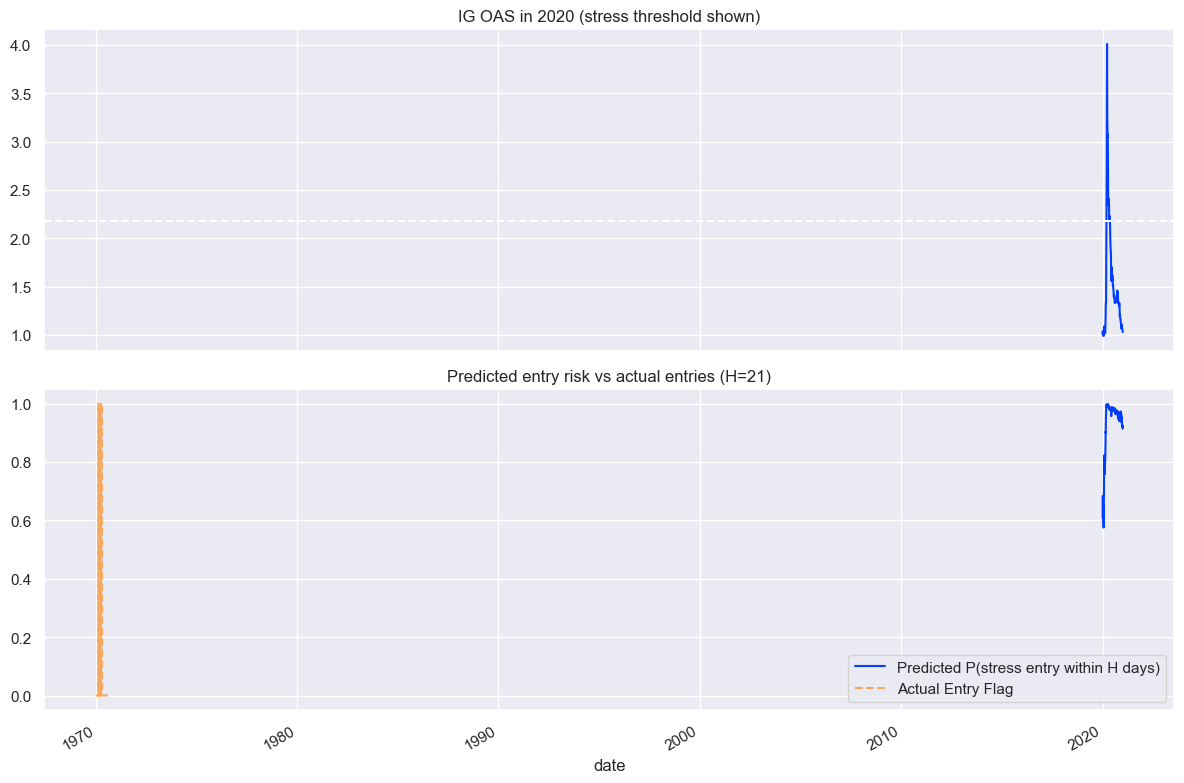

In [30]:
import matplotlib.pyplot as plt

# pick a year you have in res_df:
yr = res_df["year"].iloc[-1]
mask = entry_df.index.year == yr

# refit on all prior years
train_mask = entry_df.index.year < yr
pipe.fit(X.loc[train_mask], y.loc[train_mask])
proba = pipe.predict_proba(X.loc[mask])[:, 1]

plot_df = entry_df.loc[mask].copy()
plot_df["entry_prob"] = proba

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_df["ig_oas"].plot(ax=ax[0])
ax[0].axhline(stress_threshold, linestyle="--")
ax[0].set_title(f"IG OAS in {yr} (stress threshold shown)")

plot_df["entry_prob"].plot(ax=ax[1], label="Predicted P(stress entry within H days)")
ax[1].plot(plot_df["stress_entry_H"].values, linestyle="--", alpha=0.6, label="Actual Entry Flag")
ax[1].set_title(f"Predicted entry risk vs actual entries (H={H})")
ax[1].legend()

plt.tight_layout()
plt.show()

In [31]:
print(res_df)
print(weighted_auc, pooled_auc)
print(y.sum())

   year       auc  n_obs  n_entries
0  2008  0.456000    251          1
1  2009  0.155398    250         31
2  2011  0.316532    250          2
3  2012  0.430144    249         40
4  2016  0.400652    250         20
5  2020  0.671222    251         21
0.4051859186134172 0.3808519982433026
135


In [32]:
res_df

,year,auc,n_obs,n_entries
0,2008,0.456000,251,1
1,2009,0.155398,250,31
2,2011,0.316532,250,2
3,2012,0.430144,249,40
4,2016,0.400652,250,20
5,2020,0.671222,251,21


## Minimum-duration stress entry labels

In [33]:
from src.features import compute_stress_flag, stress_episode_entry, entry_within_horizon

df = df.copy().dropna(subset=["ig_oas", "dgs10", "t10y2y"]).sort_index()

stress_q = 0.90
D = 10   # minimum duration (days)
H = 21   # prediction horizon (days)

df["stress"], stress_threshold = compute_stress_flag(df, oas_col="ig_oas", stress_q=stress_q)
df["stress_entry"] = stress_episode_entry(df["stress"], min_duration=D)
df["stress_entry_H"] = entry_within_horizon(df["stress_entry"], df["stress"], horizon=H)

stress_threshold, df[["stress", "stress_entry", "stress_entry_H"]].sum()

/Users/chadwickballoo/Coding/projects/credit_spread_regime/src/features.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entry = (qualifying & (~qualifying.shift(1).fillna(False))).astype(int)


(2.18,
 stress            729
 stress_entry        7
 stress_entry_H     16
 dtype: int64)

In [34]:
df[["ig_oas", "stress", "stress_entry", "stress_entry_H"]].tail(60)

,ig_oas,stress,stress_entry,stress_entry_H
date,,,,
2025-09-10,0.79,0,0,0
2025-09-11,0.78,0,0,0
2025-09-12,0.77,0,0,0
2025-09-15,0.75,0,0,0
2025-09-16,0.76,0,0,0
2025-09-17,0.76,0,0,0
2025-09-18,0.75,0,0,0
2025-09-19,0.74,0,0,0
2025-09-22,0.74,0,0,0


In [35]:
import numpy as np

model_df = df.copy()

# Macro changes
model_df["dgs10_chg1"] = model_df["dgs10"].diff()
model_df["t10y2y_chg1"] = model_df["t10y2y"].diff()

# Lags of levels
model_df["dgs10_lag1"] = model_df["dgs10"].shift(1)
model_df["t10y2y_lag1"] = model_df["t10y2y"].shift(1)

# Lags of changes
model_df["dgs10_chg1_lag1"] = model_df["dgs10_chg1"].shift(1)
model_df["t10y2y_chg1_lag1"] = model_df["t10y2y_chg1"].shift(1)

# Rolling vol on lagged changes (no look-ahead)
w = 20
model_df["dgs10_vol20"] = model_df["dgs10_chg1"].shift(1).rolling(w).std()
model_df["t10y2y_vol20"] = model_df["t10y2y_chg1"].shift(1).rolling(w).std()

# Interaction
model_df["rate_level_x_slope"] = model_df["dgs10_lag1"] * model_df["t10y2y_lag1"]

feature_cols = [
    "dgs10_lag1",
    "t10y2y_lag1",
    "dgs10_chg1_lag1",
    "t10y2y_chg1_lag1",
    "dgs10_vol20",
    "t10y2y_vol20",
    "rate_level_x_slope",
]

eval_df = model_df.dropna(subset=feature_cols + ["stress_entry_H"]).copy()

X = eval_df[feature_cols]
y = eval_df["stress_entry_H"]

y.value_counts(), y.mean()

(stress_entry_H
 0    7190
 1      16
 Name: count, dtype: int64,
 np.float64(0.0022203719122953097))

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

years = sorted(eval_df.index.year.unique())
min_train_years = 5

results = []
all_y = []
all_proba = []

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = eval_df.index.year.isin(train_years)
    test_idx = eval_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    if y_train.nunique() < 2 or y_test.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

res_df = pd.DataFrame(results, columns=["year", "auc", "n_obs", "n_pos"])
res_df

,year,auc,n_obs,n_pos
0,2008,0.968000,251,1
1,2011,0.094758,250,2
2,2012,0.213710,249,1
3,2020,0.554167,251,11


In [37]:
import numpy as np

weighted_auc = np.average(res_df["auc"], weights=res_df["n_obs"])
y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)
pooled_auc = roc_auc_score(y_all, proba_all)

weighted_auc, pooled_auc, res_df["auc"].describe()

(np.float64(0.45850855058919565),
 0.5788370520622041,
 count    4.000000
 mean     0.457659
 std      0.391991
 min      0.094758
 25%      0.183972
 50%      0.383938
 75%      0.657625
 max      0.968000
 Name: auc, dtype: float64)

In [38]:
print(res_df)
print(weighted_auc, pooled_auc)
print(y.sum())

   year       auc  n_obs  n_pos
0  2008  0.968000    251      1
1  2011  0.094758    250      2
2  2012  0.213710    249      1
3  2020  0.554167    251     11
0.45850855058919565 0.5788370520622041
16


## Forward OAS widening targets

In [39]:
import numpy as np

df = df.copy().sort_index()
df["ig_oas_bps"] = df["ig_oas"] * 100

H = 21  # horizon (trading days)
bps_threshold = 25  # widening threshold in bps

# Forward max OAS over next H days
df["ig_oas_fwd_max"] = (
    df["ig_oas_bps"]
      .shift(-1)
      .rolling(H, min_periods=H)
      .max()
)

# Forward max widening (in bps)
df["ig_oas_fwd_widening"] = df["ig_oas_fwd_max"] - df["ig_oas_bps"]

# Binary target
df[f"widen_{bps_threshold}bps_{H}d"] = (
    df["ig_oas_fwd_widening"] >= bps_threshold
).astype(int)

df[[ "ig_oas", "ig_oas_fwd_widening", f"widen_{bps_threshold}bps_{H}d" ]].tail(30)

,ig_oas,ig_oas_fwd_widening,widen_25bps_21d
date,,,
2025-10-23,0.78,3.0,0
2025-10-24,0.77,4.0,0
2025-10-27,0.76,5.0,0
2025-10-28,0.76,5.0,0
2025-10-29,0.75,6.0,0
2025-10-30,0.77,4.0,0
2025-10-31,0.80,3.0,0
2025-11-03,0.83,0.0,0
2025-11-04,0.83,0.0,0


In [40]:
y = df[f"widen_{bps_threshold}bps_{H}d"]
y.value_counts(), y.mean()

(widen_25bps_21d
 0    6837
 1     390
 Name: count, dtype: int64,
 np.float64(0.053964300539643004))

In [41]:
prettyTable(df, 'widen_25bps_21d')

,count,ratio
widen_25bps_21d,,
0,6837,0.946036
1,390,0.053964


In [42]:
target_col = "widen_25bps_21d"

eval_df = df.dropna(subset=feature_cols + [target_col]).copy()

X = eval_df[feature_cols]
y = eval_df[target_col]

y.value_counts(), y.mean()

(widen_25bps_21d
 0    6816
 1     390
 Name: count, dtype: int64,
 np.float64(0.05412156536219817))

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

years = sorted(eval_df.index.year.unique())
min_train_years = 5

results = []
all_y = []
all_proba = []

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_idx = eval_df.index.year.isin(train_years)
    test_idx = eval_df.index.year == test_year

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    if y_train.nunique() < 2 or y_test.nunique() < 2:
        continue

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

    all_y.append(y_test)
    all_proba.append(pd.Series(y_proba, index=y_test.index))

res_df = pd.DataFrame(
    results,
    columns=["year", "auc", "n_obs", "n_pos"]
)

res_df

,year,auc,n_obs,n_pos
0,2002,0.626168,250,36
1,2003,0.254694,250,5
2,2008,0.399652,251,41
3,2009,0.673873,250,131
4,2010,0.165806,250,8
5,2011,0.821277,250,15
6,2012,0.535354,249,18
7,2016,0.671241,250,21
8,2019,0.274390,250,4
9,2020,0.898061,251,64


In [44]:
weighted_auc = np.average(res_df["auc"], weights=res_df["n_obs"])

y_all = pd.concat(all_y)
proba_all = pd.concat(all_proba)
pooled_auc = roc_auc_score(y_all, proba_all)

weighted_auc, pooled_auc, res_df["auc"].describe()

(np.float64(0.5405270566174623),
 0.6290406573396756,
 count    11.000000
 mean      0.540477
 std       0.238487
 min       0.165806
 25%       0.337021
 50%       0.624732
 75%       0.672557
 max       0.898061
 Name: auc, dtype: float64)

In [45]:
print(res_df)
print(weighted_auc, pooled_auc)

    year       auc  n_obs  n_pos
0   2002  0.626168    250     36
1   2003  0.254694    250      5
2   2008  0.399652    251     41
3   2009  0.673873    250    131
4   2010  0.165806    250      8
5   2011  0.821277    250     15
6   2012  0.535354    249     18
7   2016  0.671241    250     21
8   2019  0.274390    250      4
9   2020  0.898061    251     64
10  2022  0.624732    249     16
0.5405270566174623 0.6290406573396756


## Creating a Grid to look at both time horizon and spread widening

In [46]:
# Helper: build widening target (in bps)

# import numpy as np
# import pandas as pd
#
# def make_forward_widen_target(df: pd.DataFrame, H: int, bps: int,
#                              oas_col: str = "ig_oas") -> pd.Series:
#     """
#     Binary label: 1 if max widening over next H days >= bps (basis points).
#     Uses OAS reported in percent -> converts to bps via *100.
#     """
#     oas_bps = df[oas_col] * 100.0
#
#     fwd_max = oas_bps.shift(-1).rolling(H, min_periods=H).max()
#     fwd_widen = fwd_max - oas_bps
#
#     y = (fwd_widen >= bps).astype(int)
#     y.name = f"widen_{bps}bps_{H}d"
#     return y

from src.targets import make_forward_widen_target
from src.config import LOCKED_SIGNALS

for s in LOCKED_SIGNALS:
    df[make_forward_widen_target(df, "ig_oas", s["horizon"], s["bps"]).name] = \
        make_forward_widen_target(df, "ig_oas", s["horizon"], s["bps"])

In [47]:
# for s in LOCKED_SIGNALS:
#     col = f"widen_{s['bps']}bps_{s['horizon']}d"
#     print(col, df[col].mean(), df[col].sum())

In [48]:
# Helper: walk-forward AUC

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

def walk_forward_auc(eval_df: pd.DataFrame, feature_cols: list[str], target_col: str,
                     min_train_years: int = 5) -> dict:
    """
    Walk-forward by year. Returns pooled AUC, weighted AUC, per-year results, and prevalence.
    """
    df_ = eval_df.dropna(subset=feature_cols + [target_col]).copy()
    X = df_[feature_cols]
    y = df_[target_col]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ])

    years = sorted(df_.index.year.unique())
    results = []
    all_y = []
    all_proba = []

    for i in range(min_train_years, len(years)):
        train_years = years[:i]
        test_year = years[i]

        train_idx = df_.index.year.isin(train_years)
        test_idx = df_.index.year == test_year

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_test, y_test = X.loc[test_idx], y.loc[test_idx]

        # Need both classes in train and test
        if y_train.nunique() < 2 or y_test.nunique() < 2:
            continue

        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        results.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

        all_y.append(y_test)
        all_proba.append(pd.Series(y_proba, index=y_test.index))

    res_df = pd.DataFrame(results, columns=["year", "auc", "n_obs", "n_pos"])

    # Aggregate AUCs
    weighted_auc = np.average(res_df["auc"], weights=res_df["n_obs"]) if len(res_df) else np.nan
    pooled_auc = roc_auc_score(pd.concat(all_y), pd.concat(all_proba)) if all_y else np.nan

    return {
        "target": target_col,
        "n": int(y.shape[0]),
        "pos": int(y.sum()),
        "pos_rate": float(y.mean()),
        "weighted_auc": float(weighted_auc),
        "pooled_auc": float(pooled_auc),
        "by_year": res_df,
    }

In [49]:
# Running the grid
# Ensure df is sorted and has macro features already computed
df = df.sort_index().copy()

Hs = [21, 63, 126]
bps_list = [10, 25, 50]

grid_rows = []
grid_details = {}  # store per-year dfs if you want to inspect later

for H in Hs:
    for bps in bps_list:
        target_col = f"widen_{bps}bps_{H}d"
        df[target_col] = make_forward_widen_target(df, oas_col="ig_oas", horizon=H, widen_bps=bps)


        out = walk_forward_auc(df, feature_cols=feature_cols, target_col=target_col, min_train_years=5)

        grid_rows.append({
            "H_days": H,
            "bps": bps,
            "pos_rate": out["pos_rate"],
            "pos": out["pos"],
            "pooled_auc": out["pooled_auc"],
            "weighted_auc": out["weighted_auc"],
        })

        grid_details[(H, bps)] = out["by_year"]

grid_df = pd.DataFrame(grid_rows).sort_values(["H_days", "bps"])
grid_df

,H_days,bps,pos_rate,pos,pooled_auc,weighted_auc
0,21,10,0.233139,1680,0.664846,0.600623
1,21,25,0.054122,390,0.629041,0.540527
2,21,50,0.018318,132,0.634047,0.785891
3,63,10,0.537746,3875,0.551740,0.550363
4,63,25,0.222870,1606,0.544731,0.473703
5,63,50,0.068970,497,0.489488,0.387951
6,126,10,0.680544,4904,0.504978,0.550238
7,126,25,0.414238,2985,0.424869,0.517454
8,126,50,0.150291,1083,0.522477,0.487063


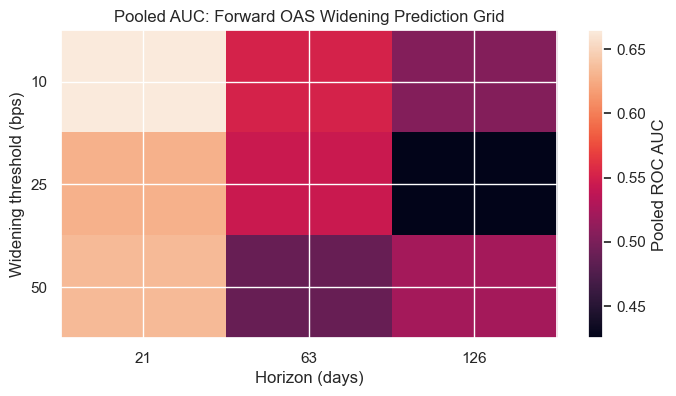

H_days,21,63,126
bps,,,
10,0.664846,0.551740,0.504978
25,0.629041,0.544731,0.424869
50,0.634047,0.489488,0.522477


In [50]:
# Heatmap of pooled auc

import matplotlib.pyplot as plt

heat = grid_df.pivot(index="bps", columns="H_days", values="pooled_auc")

plt.figure(figsize=(8, 4))
plt.imshow(heat.values, aspect="auto")
plt.xticks(range(len(heat.columns)), heat.columns)
plt.yticks(range(len(heat.index)), heat.index)
plt.colorbar(label="Pooled ROC AUC")
plt.title("Pooled AUC: Forward OAS Widening Prediction Grid")
plt.xlabel("Horizon (days)")
plt.ylabel("Widening threshold (bps)")
plt.show()

heat

In [51]:
grid_df

,H_days,bps,pos_rate,pos,pooled_auc,weighted_auc
0,21,10,0.233139,1680,0.664846,0.600623
1,21,25,0.054122,390,0.629041,0.540527
2,21,50,0.018318,132,0.634047,0.785891
3,63,10,0.537746,3875,0.551740,0.550363
4,63,25,0.222870,1606,0.544731,0.473703
5,63,50,0.068970,497,0.489488,0.387951
6,126,10,0.680544,4904,0.504978,0.550238
7,126,25,0.414238,2985,0.424869,0.517454
8,126,50,0.150291,1083,0.522477,0.487063


In [52]:
heat

H_days,21,63,126
bps,,,
10,0.664846,0.551740,0.504978
25,0.629041,0.544731,0.424869
50,0.634047,0.489488,0.522477


## Adding features based on current conditions

In [53]:
df.head()

,ig_oas,dgs10,t10y2y,regime_stress,ig_oas_chg,dgs10_chg,t10y2y_chg,ig_oas_roll_vol,ig_oas_lag1,dgs10_lag1,...,ig_oas_fwd_widening,widen_25bps_21d,widen_50bps_21d,widen_10bps_21d,widen_10bps_63d,widen_25bps_63d,widen_50bps_63d,widen_10bps_126d,widen_25bps_126d,widen_50bps_126d
date,,,,,,,,,,,,,,,,,,,,,
1996-12-31,0.60,6.43,0.55,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,0,0
1997-01-02,0.60,6.54,0.57,0,NaN,NaN,NaN,NaN,NaN,6.43,...,NaN,0,0,0,0,0,0,0,0,0
1997-01-03,0.61,6.52,0.57,0,0.01,-0.02,0.00,NaN,0.60,6.54,...,NaN,0,0,0,0,0,0,0,0,0
1997-01-06,0.61,6.54,0.57,0,0.00,0.02,0.00,NaN,0.61,6.52,...,NaN,0,0,0,0,0,0,0,0,0
1997-01-07,0.61,6.57,0.59,0,0.00,0.03,0.02,NaN,0.61,6.54,...,NaN,0,0,0,0,0,0,0,0,0


In [54]:
from src.features import add_regime_features
from src.targets import make_forward_widen_target
from src.config import LOCKED_SIGNALS

# 1) Add regime features
df = add_regime_features(
    df,
    oas_col="ig_oas",
    slope_col="t10y2y",
    dgs10_col="dgs10",
    oas_lookback=756,
    vol_lookback=20,
    lag=1,
)

# 2) Create locked widening targets (adds 10/25/50 if LOCKED_SIGNALS has them)
for s in LOCKED_SIGNALS:
    H = s["horizon"]
    bps = s["bps"]
    col = f"widen_{bps}bps_{H}d"
    df[col] = make_forward_widen_target(df, oas_col="ig_oas", horizon=H, widen_bps=bps)

# 3) Define regime columns to append
regime_cols = [
    "oas_pctile_lag1",
    "oas_z_lag1",
    "oas_tight_lag1",
    "oas_mid_lag1",
    "oas_wide_lag1",
    "curve_inverted_lag1",
    "dgs10_vol20_lag1",
    "rates_vol_high_lag1",
    "inv_x_vol_lag1",
    "wide_x_inv_lag1",
    "wide_x_vol_lag1",
]

missing = [c for c in regime_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing regime columns: {missing}")

feature_cols_regime = feature_cols + regime_cols

# 4) Evaluate baseline vs regime across ALL locked targets
targets_to_report = [f"widen_{s['bps']}bps_{s['horizon']}d" for s in LOCKED_SIGNALS]

rows = []
details = {}

for target_col in targets_to_report:
    out_base = walk_forward_auc(df, feature_cols=feature_cols, target_col=target_col, min_train_years=5)
    out_reg  = walk_forward_auc(df, feature_cols=feature_cols_regime, target_col=target_col, min_train_years=5)

    rows.append({
        "target": target_col,
        "pos_rate": out_base["pos_rate"],
        "baseline_pooled_auc": out_base["pooled_auc"],
        "baseline_weighted_auc": out_base["weighted_auc"],
        "regime_pooled_auc": out_reg["pooled_auc"],
        "regime_weighted_auc": out_reg["weighted_auc"],
    })

    details[(target_col, "baseline")] = out_base["by_year"]
    details[(target_col, "regime")] = out_reg["by_year"]

results_regime = pd.DataFrame(rows).sort_values("target")
results_regime


,target,pos_rate,baseline_pooled_auc,baseline_weighted_auc,regime_pooled_auc,regime_weighted_auc
0,widen_25bps_21d,0.054114,0.62770,0.540263,0.668620,0.619465
1,widen_50bps_21d,0.018316,0.62511,0.810921,0.757504,0.848718


In [55]:
results_regime.T

,0,1
target,widen_25bps_21d,widen_50bps_21d
pos_rate,0.054114,0.018316
baseline_pooled_auc,0.6277,0.62511
baseline_weighted_auc,0.540263,0.810921
regime_pooled_auc,0.66862,0.757504
regime_weighted_auc,0.619465,0.848718


In [56]:
display(details[("widen_25bps_21d", "baseline")])
display(details[("widen_25bps_21d", "regime")])

display(details[("widen_50bps_21d", "baseline")])
display(details[("widen_50bps_21d", "regime")])

,year,auc,n_obs,n_pos
0,2002,0.619029,250,36
1,2003,0.284082,250,5
2,2008,0.395238,251,41
3,2009,0.675605,250,131
4,2010,0.192665,250,8
5,2011,0.823546,250,15
6,2012,0.565657,249,18
7,2016,0.670410,250,21
8,2019,0.230691,250,4
9,2020,0.901153,251,64


,year,auc,n_obs,n_pos
0,2003,0.657143,250,5
1,2008,0.420906,251,41
2,2009,0.694143,250,131
3,2010,0.220558,250,8
4,2011,0.794610,250,15
5,2012,0.975228,249,18
6,2016,0.542732,250,21
7,2019,0.704268,250,4
8,2020,0.736297,251,64
9,2022,0.449839,249,16


,year,auc,n_obs,n_pos
0,2008,0.880000,251,1
1,2009,0.639073,250,85
2,2011,0.858871,250,2
3,2020,0.865245,251,36


,year,auc,n_obs,n_pos
0,2008,0.984000,251,1
1,2009,0.789234,250,85
2,2011,0.778226,250,2
3,2020,0.842894,251,36


## Running the full pipeline

In [57]:
# df
# feature_cols
# regime_cols
# feature_cols_regime
# df[['widen_10bps_21d', 'widen_25bps_21d', 'widen_50bps_21d']]

In [58]:
# Imports
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [59]:
# Walk-forward scorer that returns OOS probabilities + coefficients
def walk_forward_oos_predictions(
    df: pd.DataFrame,
    feature_cols: list[str],
    target_col: str,
    min_train_years: int = 5,
    model_kwargs: dict | None = None,
) -> dict:
    """
    Walk-forward (expanding window by year). Returns:
      - oos_proba: pd.Series of out-of-sample predicted probabilities
      - oos_y: pd.Series of true labels aligned to oos_proba
      - by_year: pd.DataFrame (year, auc, n_obs, n_pos)
      - coefs_by_year: pd.DataFrame (year x features) of logistic coefficients
      - pooled_auc, weighted_auc
    """
    model_kwargs = model_kwargs or {}
    df_ = df.dropna(subset=feature_cols + [target_col]).copy()
    X = df_[feature_cols]
    y = df_[target_col].astype(int)

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            **model_kwargs
        ))
    ])

    years = sorted(df_.index.year.unique())
    by_year_rows = []
    oos_proba_list = []
    oos_y_list = []
    coef_rows = []

    for i in range(min_train_years, len(years)):
        train_years = years[:i]
        test_year = years[i]

        train_idx = df_.index.year.isin(train_years)
        test_idx = df_.index.year == test_year

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_test, y_test = X.loc[test_idx], y.loc[test_idx]

        # Require both classes in train and test
        if y_train.nunique() < 2 or y_test.nunique() < 2:
            continue

        pipe.fit(X_train, y_train)
        proba = pipe.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, proba)
        by_year_rows.append((test_year, auc, int(test_idx.sum()), int(y_test.sum())))

        oos_proba_list.append(pd.Series(proba, index=y_test.index, name="proba"))
        oos_y_list.append(y_test.rename("y"))

        # coefficients in standardized feature space (after scaling)
        coefs = pipe.named_steps["clf"].coef_.ravel()
        coef_rows.append(pd.Series(coefs, index=feature_cols, name=test_year))

    by_year = pd.DataFrame(by_year_rows, columns=["year", "auc", "n_obs", "n_pos"])

    oos_proba = pd.concat(oos_proba_list).sort_index() if oos_proba_list else pd.Series(dtype=float)
    oos_y = pd.concat(oos_y_list).sort_index() if oos_y_list else pd.Series(dtype=int)

    pooled_auc = roc_auc_score(oos_y, oos_proba) if len(oos_y) else np.nan
    weighted_auc = np.average(by_year["auc"], weights=by_year["n_obs"]) if len(by_year) else np.nan

    coefs_by_year = pd.DataFrame(coef_rows) if coef_rows else pd.DataFrame(columns=feature_cols)

    return {
        "oos_proba": oos_proba,
        "oos_y": oos_y,
        "by_year": by_year,
        "pooled_auc": float(pooled_auc),
        "weighted_auc": float(weighted_auc),
        "coefs_by_year": coefs_by_year,
    }

In [60]:
# Run OOS scoring for each target (baseline vs regime)
LOCKED_TARGETS = ["widen_10bps_21d", "widen_25bps_21d", "widen_50bps_21d"]

results = {}
for tgt in LOCKED_TARGETS:
    results[(tgt, "baseline")] = walk_forward_oos_predictions(
        df=df,
        feature_cols=feature_cols,
        target_col=tgt,
        min_train_years=5,
        model_kwargs={"C": 1.0}
    )
    results[(tgt, "regime")] = walk_forward_oos_predictions(
        df=df,
        feature_cols=feature_cols_regime,
        target_col=tgt,
        min_train_years=5,
        model_kwargs={"C": 1.0}
    )

summary_rows = []
for tgt in LOCKED_TARGETS:
    b = results[(tgt, "baseline")]
    r = results[(tgt, "regime")]
    # pos_rate computed on rows used for the model (same df dropna)
    used = df.dropna(subset=(feature_cols_regime + [tgt]))[tgt].astype(int)
    summary_rows.append({
        "target": tgt,
        "pos_rate": float(used.mean()),
        "baseline_pooled_auc": b["pooled_auc"],
        "baseline_weighted_auc": b["weighted_auc"],
        "regime_pooled_auc": r["pooled_auc"],
        "regime_weighted_auc": r["weighted_auc"],
    })

pd.DataFrame(summary_rows).sort_values("target")

,target,pos_rate,baseline_pooled_auc,baseline_weighted_auc,regime_pooled_auc,regime_weighted_auc
0,widen_10bps_21d,0.239427,0.65957,0.594618,0.662114,0.535469
1,widen_25bps_21d,0.055914,0.62770,0.540263,0.668620,0.619465
2,widen_50bps_21d,0.018925,0.62511,0.810921,0.757504,0.848718


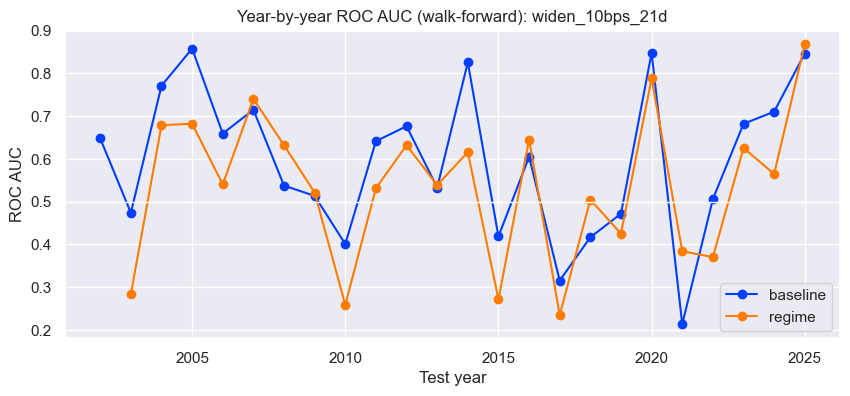

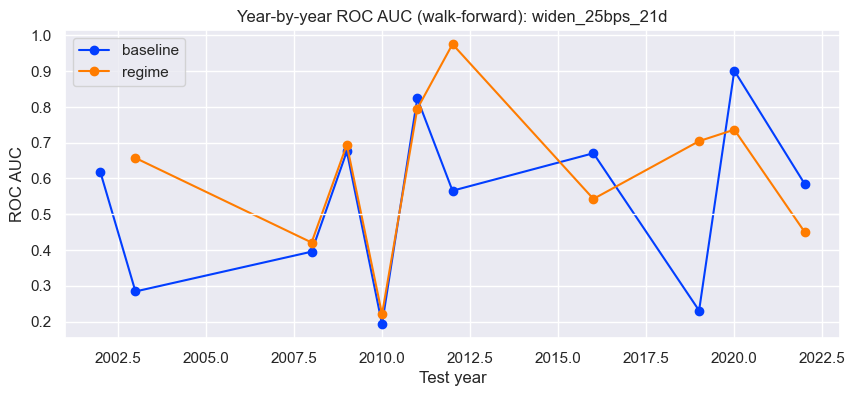

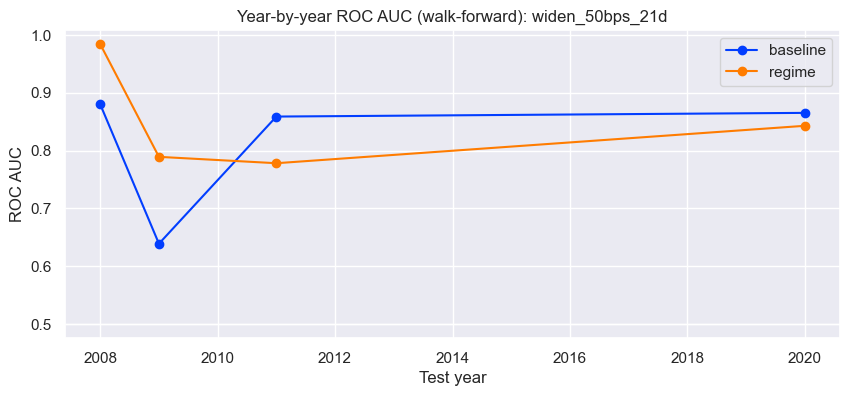

In [61]:
# Year-by-year AUC plot (baseline vs regime)
def plot_yearly_auc(target: str):
    by_b = results[(target, "baseline")]["by_year"].copy()
    by_r = results[(target, "regime")]["by_year"].copy()

    plt.figure(figsize=(10, 4))
    plt.plot(by_b["year"], by_b["auc"], marker="o", label="baseline")
    plt.plot(by_r["year"], by_r["auc"], marker="o", label="regime")
    plt.axhline(0.5, linewidth=1)
    plt.title(f"Year-by-year ROC AUC (walk-forward): {target}")
    plt.xlabel("Test year")
    plt.ylabel("ROC AUC")
    plt.legend()
    plt.show()

for tgt in LOCKED_TARGETS:
    plot_yearly_auc(tgt)

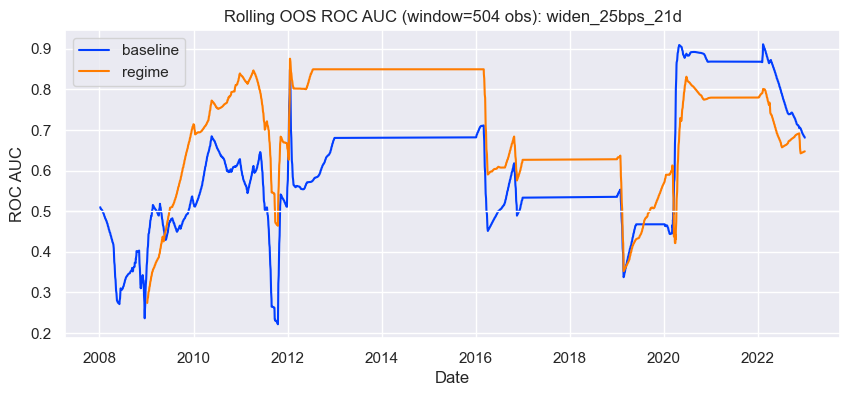

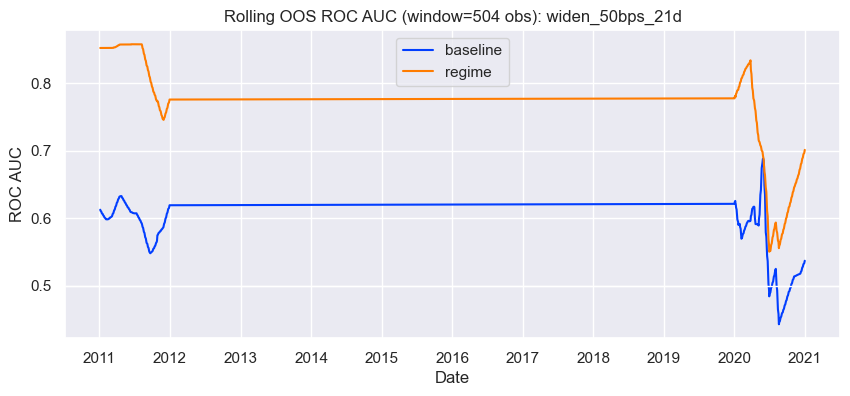

In [62]:
# Rolling AUC on OOS predictions (stability over time)
def rolling_auc(oos_y: pd.Series, oos_proba: pd.Series, window: int = 504, min_pos: int = 10) -> pd.Series:
    """
    Rolling ROC AUC over time using OOS predictions.
    window: number of observations (e.g., 504 ~ 2 years of trading days)
    min_pos: require at least min_pos positives AND min_pos negatives in the window
    """
    dfp = pd.DataFrame({"y": oos_y, "p": oos_proba}).dropna().sort_index()
    aucs = []
    idxs = []

    for i in range(window, len(dfp) + 1):
        w = dfp.iloc[i - window:i]
        n_pos = int(w["y"].sum())
        n_neg = int((1 - w["y"]).sum())
        if n_pos < min_pos or n_neg < min_pos:
            aucs.append(np.nan)
        else:
            aucs.append(roc_auc_score(w["y"], w["p"]))
        idxs.append(w.index[-1])

    return pd.Series(aucs, index=idxs, name="rolling_auc")

def plot_rolling_auc(target: str, window: int = 504):
    b = results[(target, "baseline")]
    r = results[(target, "regime")]

    rb = rolling_auc(b["oos_y"], b["oos_proba"], window=window)
    rr = rolling_auc(r["oos_y"], r["oos_proba"], window=window)

    plt.figure(figsize=(10, 4))
    plt.plot(rb.index, rb.values, label="baseline")
    plt.plot(rr.index, rr.values, label="regime")
    plt.axhline(0.5, linewidth=1)
    plt.title(f"Rolling OOS ROC AUC (window={window} obs): {target}")
    plt.xlabel("Date")
    plt.ylabel("ROC AUC")
    plt.legend()
    plt.show()

# Recommended: focus on 25bps and 50bps for rolling stability
for tgt in ["widen_25bps_21d", "widen_50bps_21d"]:
    plot_rolling_auc(tgt, window=504)


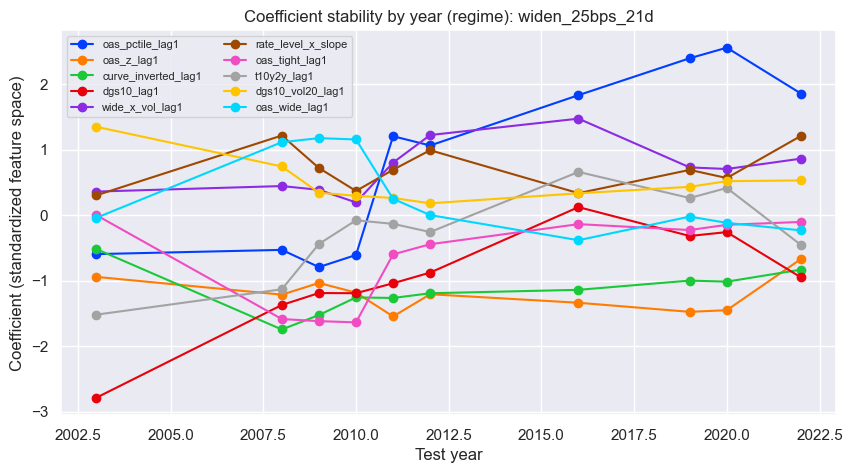

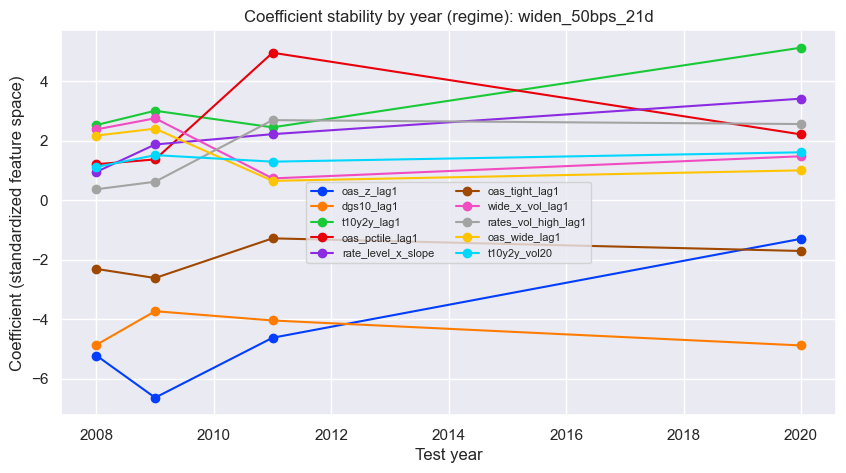

In [63]:
# Coefficient stability (linear-only)
def plot_coef_stability(target: str, top_k: int = 10, use_regime: bool = True):
    key = (target, "regime" if use_regime else "baseline")
    coef_df = results[key]["coefs_by_year"].copy()
    if coef_df.empty:
        print("No coefficients available (likely due to skipped years).")
        return

    # Choose the most important features by average absolute coefficient
    avg_abs = coef_df.abs().mean(axis=0).sort_values(ascending=False)
    top_features = avg_abs.head(top_k).index.tolist()

    plt.figure(figsize=(10, 5))
    for f in top_features:
        plt.plot(coef_df.index, coef_df[f], marker="o", label=f)
    plt.title(f"Coefficient stability by year ({'regime' if use_regime else 'baseline'}): {target}")
    plt.xlabel("Test year")
    plt.ylabel("Coefficient (standardized feature space)")
    plt.legend(ncol=2, fontsize=8)
    plt.show()

plot_coef_stability("widen_25bps_21d", top_k=10, use_regime=True)
plot_coef_stability("widen_50bps_21d", top_k=10, use_regime=True)

In [64]:
# Alert metrics for top-q% thresholds
def calibration_top_qpct(oos_y: pd.Series, oos_proba: pd.Series, q: float = 0.95) -> dict:
    """
    Global threshold: alert if proba >= quantile(q) over all OOS predictions.
    Returns precision/recall and alert rate.
    """
    dfp = pd.DataFrame({"y": oos_y, "p": oos_proba}).dropna()
    thr = dfp["p"].quantile(q)
    alert = (dfp["p"] >= thr).astype(int)

    tp = int(((alert == 1) & (dfp["y"] == 1)).sum())
    fp = int(((alert == 1) & (dfp["y"] == 0)).sum())
    fn = int(((alert == 0) & (dfp["y"] == 1)).sum())

    precision = tp / (tp + fp) if (tp + fp) else np.nan
    recall = tp / (tp + fn) if (tp + fn) else np.nan
    alert_rate = float(alert.mean())

    return {"threshold": float(thr), "alert_rate": alert_rate, "precision": precision, "recall": recall, "tp": tp, "fp": fp, "fn": fn}

def calibration_top_qpct_by_year(oos_y: pd.Series, oos_proba: pd.Series, q: float = 0.95) -> pd.DataFrame:
    """
    Per-year threshold: compute q-quantile threshold within each year.
    Returns per-year precision/recall.
    """
    dfp = pd.DataFrame({"y": oos_y, "p": oos_proba}).dropna()
    dfp["year"] = dfp.index.year

    rows = []
    for yr, g in dfp.groupby("year"):
        if g["y"].nunique() < 2:
            continue
        thr = g["p"].quantile(q)
        alert = (g["p"] >= thr).astype(int)

        tp = int(((alert == 1) & (g["y"] == 1)).sum())
        fp = int(((alert == 1) & (g["y"] == 0)).sum())
        fn = int(((alert == 0) & (g["y"] == 1)).sum())

        precision = tp / (tp + fp) if (tp + fp) else np.nan
        recall = tp / (tp + fn) if (tp + fn) else np.nan

        rows.append({"year": yr, "threshold": float(thr), "precision": precision, "recall": recall,
                     "alerts": int(alert.sum()), "n": int(len(g)), "pos": int(g["y"].sum())})

    return pd.DataFrame(rows).sort_values("year")

def run_calibration_tables(target: str, q_list=(0.90, 0.95, 0.99)):
    out = []
    for variant in ["baseline", "regime"]:
        oos_y = results[(target, variant)]["oos_y"]
        oos_p = results[(target, variant)]["oos_proba"]
        for q in q_list:
            m = calibration_top_qpct(oos_y, oos_p, q=q)
            out.append({"target": target, "variant": variant, "q": q, **m})
    return pd.DataFrame(out)

calib_25 = run_calibration_tables("widen_25bps_21d", q_list=(0.90, 0.95, 0.99))
calib_50 = run_calibration_tables("widen_50bps_21d", q_list=(0.90, 0.95, 0.99))

calib_25, calib_50


(            target   variant     q  threshold  alert_rate  precision  \
 0  widen_25bps_21d  baseline  0.90   0.943569    0.100000   0.218182   
 1  widen_25bps_21d  baseline  0.95   0.976723    0.050182   0.246377   
 2  widen_25bps_21d  baseline  0.99   0.994384    0.010182   0.107143   
 3  widen_25bps_21d    regime  0.90   0.990031    0.100000   0.028000   
 4  widen_25bps_21d    regime  0.95   0.999617    0.050000   0.040000   
 5  widen_25bps_21d    regime  0.99   0.999959    0.010000   0.000000   
 
      recall  tp   fp   fn  
 0  0.167131  60  215  299  
 1  0.094708  34  104  325  
 2  0.008357   3   25  356  
 3  0.021672   7  243  316  
 4  0.015480   5  120  318  
 5  0.000000   0   25  323  ,
             target   variant     q  threshold  alert_rate  precision  \
 0  widen_50bps_21d  baseline  0.90   0.999257    0.100798   0.207921   
 1  widen_50bps_21d  baseline  0.95   0.999997    0.050898   0.176471   
 2  widen_50bps_21d  baseline  0.99   1.000000    0.010978   0.0

In [65]:
# per-year threshold calibration:
calib_25_by_year = calibration_top_qpct_by_year(
    results[("widen_25bps_21d", "regime")]["oos_y"],
    results[("widen_25bps_21d", "regime")]["oos_proba"],
    q=0.95
)
calib_25_by_year


,year,threshold,precision,recall,alerts,n,pos
0,2003,0.999986,0.000000,0.000000,13,250,5
1,2008,0.975667,0.384615,0.121951,13,251,41
2,2009,0.979586,0.538462,0.053435,13,250,131
3,2010,0.957334,0.000000,0.000000,13,250,8
4,2011,0.989292,0.000000,0.000000,13,250,15
5,2012,0.829963,0.615385,0.444444,13,249,18
6,2016,0.465382,0.230769,0.142857,13,250,21
7,2019,0.500538,0.000000,0.000000,13,250,4
8,2020,0.819580,0.692308,0.140625,13,251,64
9,2022,0.865394,0.000000,0.000000,13,249,16


In [66]:
# per-year threshold calibration:
calib_50_by_year = calibration_top_qpct_by_year(
    results[("widen_50bps_21d", "regime")]["oos_y"],
    results[("widen_50bps_21d", "regime")]["oos_proba"],
    q=0.95
)
calib_50_by_year


,year,threshold,precision,recall,alerts,n,pos
0,2008,0.999702,0.076923,1.000000,13,251,1
1,2009,0.999994,1.000000,0.152941,13,250,85
2,2011,0.999866,0.000000,0.000000,13,250,2
3,2020,0.251184,0.153846,0.055556,13,251,36


In [67]:
# Precision@N (top N risk days per year)
def precision_at_n_by_year(oos_y: pd.Series, oos_proba: pd.Series, n: int = 20) -> pd.DataFrame:
    dfp = pd.DataFrame({"y": oos_y, "p": oos_proba}).dropna()
    dfp["year"] = dfp.index.year

    rows = []
    for yr, g in dfp.groupby("year"):
        if len(g) < n:
            continue
        top = g.sort_values("p", ascending=False).head(n)
        tp = int(top["y"].sum())
        precision = tp / n
        total_pos = int(g["y"].sum())
        recall = tp / total_pos if total_pos else np.nan
        rows.append({"year": yr, "N": n, "precision@N": precision, "recall@N": recall, "tp": tp, "pos": total_pos})
    return pd.DataFrame(rows).sort_values("year")

p20_50 = precision_at_n_by_year(
    results[("widen_50bps_21d", "regime")]["oos_y"],
    results[("widen_50bps_21d", "regime")]["oos_proba"],
    n=20
)
p10_50 = precision_at_n_by_year(
    results[("widen_50bps_21d", "regime")]["oos_y"],
    results[("widen_50bps_21d", "regime")]["oos_proba"],
    n=10
)

p10_50, p20_50


(   year   N  precision@N  recall@N  tp  pos
 0  2008  10          0.1  1.000000   1    1
 1  2009  10          1.0  0.117647  10   85
 2  2011  10          0.0  0.000000   0    2
 3  2020  10          0.2  0.055556   2   36,
    year   N  precision@N  recall@N  tp  pos
 0  2008  20         0.05  1.000000   1    1
 1  2009  20         0.95  0.223529  19   85
 2  2011  20         0.00  0.000000   0    2
 3  2020  20         0.25  0.138889   5   36)

In [68]:
# Building a PM-style “daily signal + action” table
def build_overlay_table(
    target: str,
    variant: str = "regime",
    q: float = 0.95,
    action_mode: str = "throttle",  # "throttle" or "hedge"
) -> pd.DataFrame:
    oos_y = results[(target, variant)]["oos_y"]
    oos_p = results[(target, variant)]["oos_proba"]
    dfp = pd.DataFrame({"y_true": oos_y, "score": oos_p}).dropna().sort_index()

    thr = dfp["score"].quantile(q)
    dfp["alert"] = (dfp["score"] >= thr).astype(int)

    # Optional: join regime tags from df (lagged, leakage-safe)
    join_cols = [c for c in ["oas_wide_lag1", "curve_inverted_lag1", "rates_vol_high_lag1"] if c in df.columns]
    if join_cols:
        dfp = dfp.join(df[join_cols], how="left")

    # Simple action rules
    if action_mode == "throttle":
        # Example: reduce risk when alert=1
        dfp["action"] = np.where(dfp["alert"] == 1, "Reduce credit beta", "Normal risk")
    elif action_mode == "hedge":
        dfp["action"] = np.where(dfp["alert"] == 1, "Add/scale hedge", "No hedge overlay")
    else:
        dfp["action"] = np.where(dfp["alert"] == 1, "Defensive posture", "Neutral posture")

    dfp.attrs["threshold"] = float(thr)
    return dfp

overlay_25 = build_overlay_table("widen_25bps_21d", variant="regime", q=0.95, action_mode="throttle")
overlay_25.tail(30), overlay_25.attrs["threshold"]


(            y_true     score  alert  oas_wide_lag1  curve_inverted_lag1  \
 date                                                                      
 2022-11-17       0  0.000930      0            1.0                  1.0   
 2022-11-18       1  0.000917      0            1.0                  1.0   
 2022-11-21       1  0.000692      0            1.0                  1.0   
 2022-11-22       1  0.000594      0            1.0                  1.0   
 2022-11-23       1  0.000574      0            1.0                  1.0   
 2022-11-25       1  0.002053      0            0.0                  1.0   
 2022-11-28       1  0.001839      0            0.0                  1.0   
 2022-11-29       0  0.001930      0            0.0                  1.0   
 2022-11-30       0  0.002086      0            0.0                  1.0   
 2022-12-01       0  0.001803      0            0.0                  1.0   
 2022-12-02       0  0.002073      0            0.0                  1.0   
 2022-12-05 

## Building overlays for visual analysis and signal detection

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

def build_overlay_df(df, results, target_col, variant="regime"):
    """
    Returns a DF indexed by date with:
      - ig_oas_bps
      - oos_proba (model score)
      - oos_y (realized label)
      - alert (based on chosen threshold series)
    """
    out = df.copy()
    out["ig_oas_bps"] = out["ig_oas"] * 100.0

    r = results[(target_col, variant)]
    # expects Series indexed by date
    out["oos_proba"] = r["oos_proba"]
    out["oos_y"] = r["oos_y"]

    return out[["ig_oas_bps", "oos_proba", "oos_y"]].dropna()

In [70]:
def plot_decision_overlay(overlay_df, threshold, title):
    """
    threshold: float or Series aligned to overlay_df.index
    """
    d = overlay_df.copy()

    if not isinstance(threshold, pd.Series):
        d["threshold"] = float(threshold)
    else:
        d["threshold"] = threshold.reindex(d.index)

    d["alert"] = (d["oos_proba"] >= d["threshold"]).astype(int)

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(d.index, d["ig_oas_bps"], label="IG OAS (bps)")
    ax1.set_ylabel("IG OAS (bps)")

    ax2 = ax1.twinx()
    ax2.plot(d.index, d["oos_proba"], label="Model proba", linestyle="--")
    ax2.plot(d.index, d["threshold"], label="Threshold", linestyle=":")
    ax2.set_ylabel("Probability")

    # mark alerts
    alerts = d[d["alert"] == 1]
    ax2.scatter(alerts.index, alerts["oos_proba"], marker="o")

    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    return d

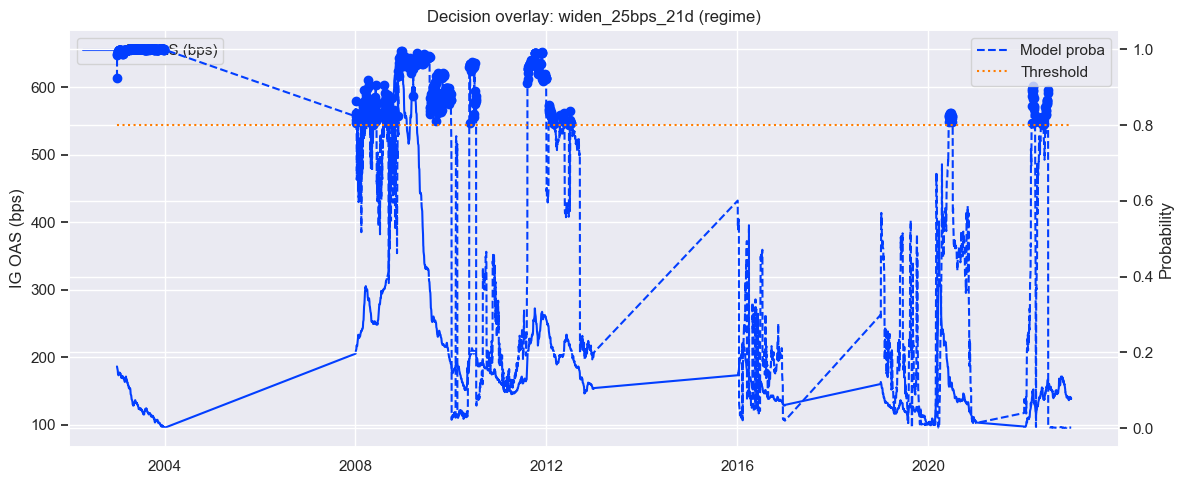

In [71]:
target = "widen_25bps_21d"
overlay = build_overlay_df(df, results, target_col=target, variant="regime")
overlay_with_alerts = plot_decision_overlay(
    overlay,
    threshold=0.8,  # placeholder; step 2 will produce calibrated thresholds
    title=f"Decision overlay: {target} (regime)"
)

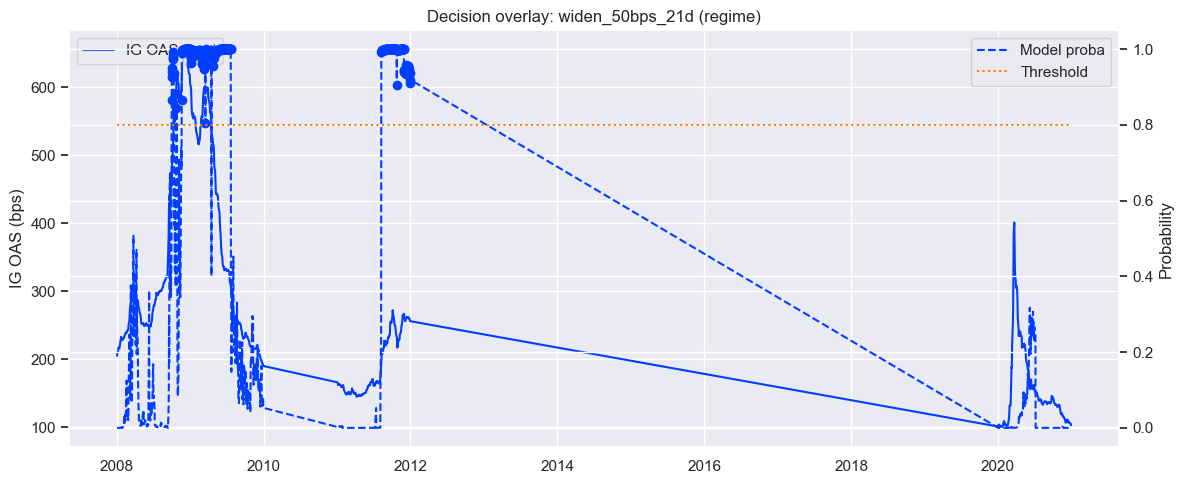

In [72]:
target = "widen_50bps_21d"
overlay = build_overlay_df(df, results, target_col=target, variant="regime")
overlay_with_alerts = plot_decision_overlay(
    overlay,
    threshold=0.8,  # placeholder; step 2 will produce calibrated thresholds
    title=f"Decision overlay: {target} (regime)"
)

In [73]:
def per_year_threshold_series(proba: pd.Series, q: float = 0.95) -> pd.Series:
    """
    Returns a Series aligned to proba.index where each date gets the threshold
    for its calendar year (based only on that year's distribution).
    """
    dfp = proba.to_frame("p").dropna()
    dfp["year"] = dfp.index.year

    thresh_by_year = dfp.groupby("year")["p"].quantile(q)
    dfp["threshold"] = dfp["year"].map(thresh_by_year)

    return dfp["threshold"].reindex(proba.index)

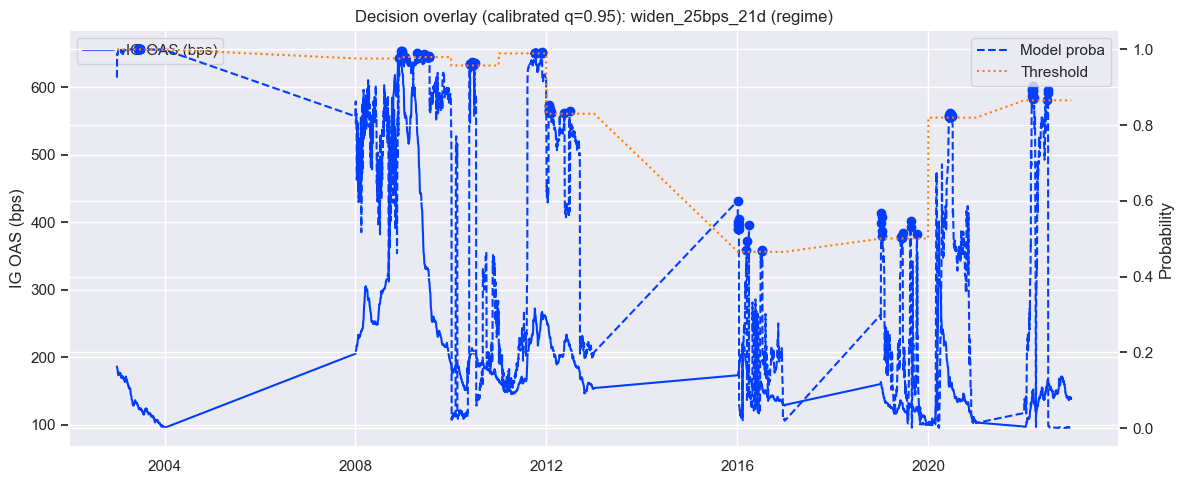

In [74]:
target = "widen_25bps_21d"
proba = results[(target, "regime")]["oos_proba"]
thr_series = per_year_threshold_series(proba, q=0.95)

overlay = build_overlay_df(df, results, target, "regime")
overlay_cal = plot_decision_overlay(
    overlay,
    threshold=thr_series,
    title=f"Decision overlay (calibrated q=0.95): {target} (regime)"
)

In [75]:
def overlay_backtest_spread_proxy(
    df: pd.DataFrame,
    alert: pd.Series,
    hold_days: int = 21,
    base_exposure: float = 1.0,
    de_risk_exposure: float = 0.25,
    oas_bps_col: str = "ig_oas_bps",
) -> pd.DataFrame:
    """
    Spread-risk proxy:
      daily_pnl ~ - exposure * ΔOAS_bps
    """
    d = df.copy()
    d = d[[oas_bps_col]].dropna()
    d["d_oas_bps"] = d[oas_bps_col].diff()

    # build exposure path: when alert fires, reduce exposure for next hold_days
    a = alert.reindex(d.index).fillna(0).astype(int)
    exposure = pd.Series(base_exposure, index=d.index, dtype=float)

    # apply de-risk windows
    idx = d.index
    alert_dates = idx[a == 1]
    for t in alert_dates:
        start = t
        end = t + pd.tseries.offsets.BDay(hold_days)
        exposure.loc[(idx >= start) & (idx < end)] = de_risk_exposure

    d["exposure"] = exposure
    d["pnl_proxy"] = -d["exposure"] * d["d_oas_bps"]
    d["pnl_proxy_cum"] = d["pnl_proxy"].cumsum()

    # baseline (always exposed)
    d["pnl_base"] = -base_exposure * d["d_oas_bps"]
    d["pnl_base_cum"] = d["pnl_base"].cumsum()

    return d


In [76]:
def plot_backtest(bt: pd.DataFrame, title: str):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(bt.index, bt["pnl_base_cum"], label="Baseline (always exposed)")
    ax.plot(bt.index, bt["pnl_proxy_cum"], label="Overlay (de-risk on alert)")
    ax.set_title(title)
    ax.set_ylabel("Cumulative proxy P&L (spread-only)")
    ax.legend()
    plt.tight_layout()
    plt.show()


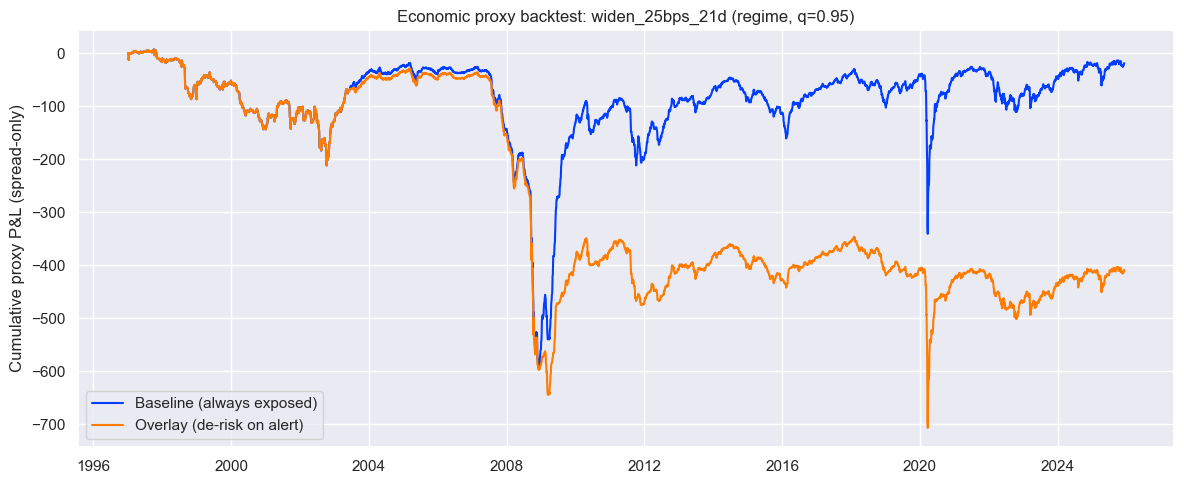

In [77]:
target = "widen_25bps_21d"
overlay = build_overlay_df(df, results, target, "regime")
thr = per_year_threshold_series(overlay["oos_proba"], q=0.95)
overlay["alert"] = (overlay["oos_proba"] >= thr).astype(int)

base = df.copy()
base["ig_oas_bps"] = base["ig_oas"] * 100.0

bt = overlay_backtest_spread_proxy(base, overlay["alert"], hold_days=21, de_risk_exposure=0.25)
plot_backtest(bt, f"Economic proxy backtest: {target} (regime, q=0.95)")

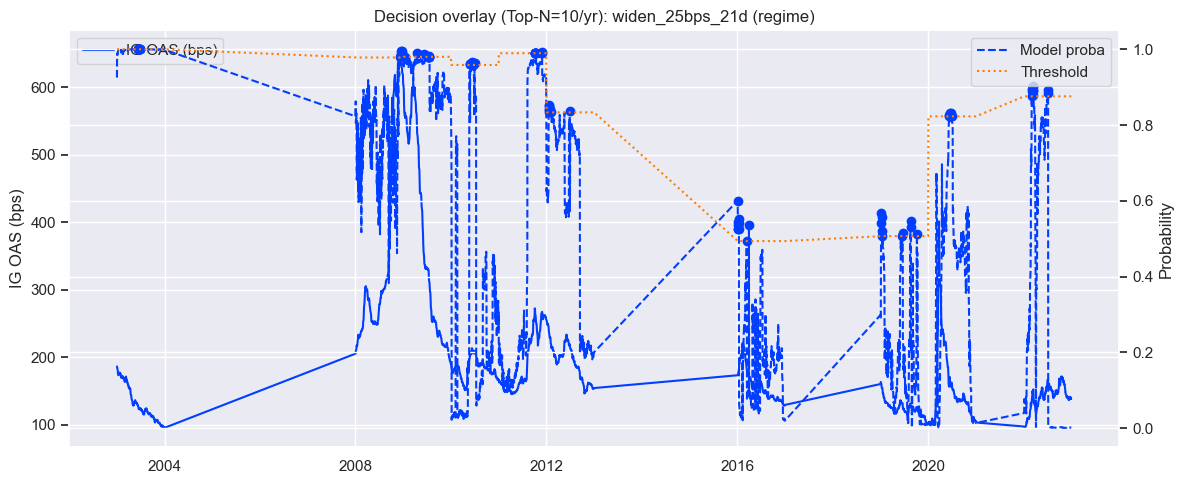

In [78]:
from src.calibration import per_year_threshold_series_top_n

target = "widen_25bps_21d"
variant = "regime"

overlay = build_overlay_df(df, results, target_col=target, variant=variant)

thr_series = per_year_threshold_series_top_n(
    results[(target, variant)]["oos_proba"],
    n=10,
)

overlay_cal = plot_decision_overlay(
    overlay,
    threshold=thr_series,
    title=f"Decision overlay (Top-N=10/yr): {target} ({variant})",
)

In [2]:
from src.data_loader import load_data

df = load_data()
print(type(df), df.shape)
print(df.index[:3])
print(df.index[-3:])
print(df.columns)


BAMLCOA0CM: 1996-12-31 -> 2025-12-08, 7648 obs
DGS10: 1962-01-02 -> 2025-12-05, 16679 obs
T10Y2Y: 1976-06-01 -> 2025-12-08, 12920 obs
<class 'pandas.core.frame.DataFrame'> (16778, 3)
DatetimeIndex(['1962-01-02', '1962-01-03', '1962-01-04'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2025-12-04', '2025-12-05', '2025-12-08'], dtype='datetime64[ns]', name='date', freq=None)
Index(['ig_oas', 'dgs10', 't10y2y'], dtype='object')


In [3]:
df = load_data()
print(df.columns)


BAMLCOA0CM: 1996-12-31 -> 2025-12-08, 7648 obs
DGS10: 1962-01-02 -> 2025-12-05, 16679 obs
T10Y2Y: 1976-06-01 -> 2025-12-08, 12920 obs
Index(['ig_oas', 'dgs10', 't10y2y'], dtype='object')
